## Student: Rodolfo Lerma

# Introduction to Recurrent Neural Networks

### Machine Learning 530
### Steve Elston

## 1.0 Introduction to neural networks

In this lesson you will explore **recurrent neural networks (RNNs)**. Recurrent neural networks use a distinctive model which is suitable for sequence data. Sequence data can include human speech, natural language, and numerical time series. Natural language applications include machine translation and question response systems. RNNs can also be applied to multi-dimensional data. For example, RNNs are used to caption images.   

The idea of RNNs is not new. In the early days of the last surge in interest in neural networks, the basic architecture was proposed by Rumelhart et. al. (1986). The idea remained in limited use, until Hochreiter and Schmidhuber proposed the Long Short Term Memory (LSTM) network in 1997. By 2007, LSTM RNNs completely dominated speach recognition, displacing decades of work on Hidden Markov Models. See, for example, Fernandez et. al (2007). RNNs remain an active area of research with improvements appearing regularly. 

In this lesson you will learn:

1. The basic concepts of RNNs. 
2. An introduction to text processing and feature embedding methods.
3. How RNNs can be used for sequence genertion. 
4. Some options for deep RNN architectures.
5. How RNN architectures can employ memory to work over different time scales. 
6. Methods for regularization of RNNs.
7. How the  bidirectional RNN architecture works. 



### 1.1 Basic recurrence relationships for neural networks

**Recurrent neural networks (RNNs)** use recurrence operations to operate on **sequences**. But, what do we mean by a recurrence? Simply put, recurrent functions are functions that call themselves to process values of a sequence. 

Let's look at a simple example. Start with a function that operates on a value at one time step to compute an output at the next time step. We can write such a function as follows:

$$s^{(t)} = f(s^{(t-1)}; \theta)$$

This apply this functional relation once again applied again to compute the output at the next time step. This first recurrent relationship can be written as follows.

$$s^{(t+1)} = f(f(s^{(t-1)}; \theta); \theta)$$

We can continue in this way to compute the output of any **finite** sequence of inputs. It is important to understand that this recurrence relationship in not defined for an infinite length sequence. In practice, all problems for which we apply the recurrence relationship are finite. 

Notice that the recurrence relationship introduces **memory**. Output values depend on the history of inputs. The memory property of this model differentiates it from many classical time series models. In technical terms we can say the recurrence model is **non-Markovian**, where a **Markov process** is memoryless.   

### 1.2 Basic recurrent neural network architecture

How do we create a neural network with a recurrence relationship? A single hidden layer recurrent neural network is illustrated in Figure 1.1 below. The hidden layer of this network has a recurrent or feedback path. This RNN produces an output value (or vector) for each input.     

<img src="img/Recurrent1.JPG" alt="Drawing" style="width:200px; height:400px"/>
<center>Figure 1.1. Basic architecture of a recurrent process</center>

Figure 1.1 illustrates the concept of an RNN. But, how can this architecture be used to perform actual computations? The answer is to **unfold** the recurrence relationship. This unfolding is illustrated in Figure 1.2. Notice that the unfolded network represents a long sequence of calculations. 

<img src="img/Unfolded1.JPG" alt="Drawing" style="width:200px; height:200px"/>
<center>Figure 1.2. Unrolled basic recurrent process</center>

The capital letters in Figure 1.2 represent weight tensors of the model. It is these weight tensors that must be learned when training an RNN. Typically, these weight tensors are learned by using **back propagation through time (BPTT)**. BPTT is a generalization of the general back propagation algorithm. 

The weight tensor $W$ defines the recurrence. You can see that this connection from one time step to another introduces memory into the model. 

Given these weight tensors the feed-forward calculation for a multinomial classifier RRN can be written as follows:  

$$a^{(t)} = b + W h^{(t-1)} + Ux^{(t)}\\
h^{(t)} = tanh(a^{(t)})\\
o^{(t)} = c + Vh^{(t)}\\
\hat{y}^{(t)} = softmax(o^{(t)})$$

These relationships are relatively complex. This is especially the case when compared to basic fully-connected networks. 

In the equations above notice that there is only a dependency on the previous activation, $h^{(t-1)}$, and the current input, $x^{(t)}$. There is no dependency on anything that occurs after the current time step. Therefore, we can stay that this basic recurrent neural network is **causal**. For many problems in sequence analysis causality is an essential property. For example, in a forecasting application there will never be any information available beyond the present. 

Notice that the weight tensors of the RNN are the same at each time step. This fact has two important implications.
1. These **Shared weight** tensors are learned. This makes the training of RNNs tractable. Further, the statistical strength of the training is increased. 
2. The RNN can only be used to model **stationary** sequences. A stationary sequence has statistical properties (e.g. variance) that are **invariant with time**.   

### 1.3 Recurrent network with single output

The RNN architecture illustrated in Figure 1.3 has only one output that is generated only once the end of the sequence is encountered. This type of RNN can be used in a number of ways. For example, the single output RNN can be used as a trigger that detects a certain pattern in a sequence. In can also be used as a classifier for the input sequence.   

<img src="img/RNNwithSingOutput.JPG" alt="Drawing" style="width:500px; height:400px"/>
<center>Figure 1.3. RNN with single output</center>

A common issue with single output RNNs is difficulty with training. BPTT requires a gradient based on the partial derivatives of the loss function weights with respect to the weights. This gradient can only be computed at the end of each sequence. This situation can greatly slow training if the sequences are long or arrive infrequently. 

## 2.0 Text example with Keras

Let's see how some of this theory works in practice using Keras. Execute the code in the cell below to load the required packages.

In [1]:
import numpy as np
from keras import layers
from keras.datasets import imdb
from keras import preprocessing, regularizers
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, Embedding, SimpleRNN, LSTM, GRU, Bidirectional
#from tensorflow.keras.layers import Flatten, Dense, Embedding, SimpleRNN, LSTM, GRU, Bidirectional
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

%matplotlib inline

### 2.1 Overview of text embedding

In the following examples we will use a feature extraction technique known as **text embedding**. A text embedding layer is often used to extract features before RNN layers are used. This general architecture is shown in Figure 2.1 

<img src="img/Architecture.JPG" alt="Drawing" style="width:250px; height:250px"/>
<center>Figure 2.1. General architecture for deep learning with text</center>

We will not dive deeply into NLP for this lesson since our focus is on RNNs. However, a bit of background will help you understand what is going on.

First a bit of terminology. We talk about a **corpus**, which a collection of **documents**. A document can take many forms; a email, a tweet, a news article, a book, a chapter from a book, a paragraph, etc. 

There are a great many models which have been tried for text analytics and **natural language processing (NLP)**. Typically, NLP with raw text requires significant preparation.  A few of many possible preparation steps include: 
- Text is normalized, which can involve many steps such as setting characters to lower case, removing punctuation, numbers and special characters. 
- In some cases, **stop words** are removed. Stop words are common words with no semantic value, such as 'the' or 'and'. 
- Normalized text is **tokenized**. There are a number of ways to tokenize text. Most commonly, the tokens are the words in the document. Tokens can also be characters or any other division of the document that make semantic sense. 

We will only discuss a few of common models briefly here: 

- The **bag of words model (BOW)** is a simple, widely used, and surprisingly effective model for analysis of text data. The BOW model assumes **exchangeability** of words. The BOW model depends only on the frequency of the words in the document. The order of the words is not considered. Despite these seemingly ridiculous assumptions, this model works well in many cases. The end product of applying the BOW model is a term-document or document-term matrix. The tdm, or dtm is a structured representation of word frequency by document. The tdm or dtm can be used for classification if labels are available or clustering for unsupervised learning. In general the tdm or dtm are extremely sparse. Most words in a typical corpus do not show up in most documents. This sparsity requires that special data structures are used for storage and manipulation. Further, the sparse representation leads to statistical issues. 
- The **N-gram** model uses all possible sequences of N words. For example, the 3-gram of the sentence 'The cat sat on the mat' are as follows:
 - All possible 1-grams; the, cat, sat, on, mat. Note that the 1-gram model is close to the BOW model. 
 - All possible 2-grams; the cat, cat sat, sat on, on the, the mat. 
 - All possible 3-grams; the cat sat, cat sat on, sat on the, on the mat. 
- Another widely used model is **Part of Speech (PoS) Tagging**. PoS tagging attempts to label or annotate words in a corpus (e.g. a collection of documents) as, say nouns, verbs, pronouns, etc. PoS tagging is beyond the  scope of this Lesson. The PoS tagger creates a tree of the relationship of words in say a sentence. One useful specialization of PoS tagging is named entity recognition, which attempts to find proper nouns. 

With the advent of deep learning, **text embedding models** have come into common use. Embedding models map the tokens (typically words) in the documents to a dense space of learned features. The dense representation has significant statistical advantages when training models. Further minimal storage is required for the dense representation. 

Similar words lie near each other in the embedding space in a manner that preserves semantic relationships. This relationship between some words is shown schematically in Figure 2.2. You can see that simpler words are close to each other. Further, words with similar semantic relationships are along nearly parallel vectors in this space.    

![](img/Embedding.JPG)
<center>Figure 2.2. Schematic diagram of embedding relationship between common words</center>

Text embedding has been shown to work extremely well in practice. Unfortunately, like many topics in deep learning, theory has not caught up with practice. Beyond the conceptual level theory is sketchy. The most readable source on the theory of embedding is the [article by Rong](https://arxiv.org/pdf/1411.2738.pdf).

### 2.2 Simple text embedding example

Let's try a simple sentiment classifier using text embedding. We will try sentiment analysis of movie review text using the IMDB dataset built into Keras. This dataset includes the full text of a number of movie reviews, along with labels indicating if the review has positive of negative sentiment. 

***
**Note.** A sentiment analysis example is not ideal to demonstrate applying RNNs to text. Most likely, this fact arises from the fact that word order of the sequence is less important in this application. 
***

The code in the cell below performs the following steps:
1. Loads the IMDB data into train and test subsets.
2. Pads the sequence of words in each review so that all sequences have the same length. In this case, the first 250 words are used. Shorter reviews are padded with zeros. Padding is required so that Keras neural networks can operate on the input. 
3. Prints some summary information on the result.

In [2]:
max_features = 10000
max_len = 250

old = np.load
#np.load.__defaults__=(None, True, True, 'ASCII')
#np.load = lambda *a,**k: old(*a,**k,allow_pickle=True)
np.load = lambda *a,**k: old(*a,allow_pickle=True)
#np.load = lambda *a: old(allow_pickle=True)
(train_text, train_labels), (test_text, test_labels) = imdb.load_data(num_words = max_features)
np.load = old
del(old)

train_text = preprocessing.sequence.pad_sequences(train_text, maxlen = max_len)
test_text = preprocessing.sequence.pad_sequences(test_text, maxlen = max_len)
print(len(train_text))
print('')
print('First Example')
print('')
print(train_text[1])

17473536/17464789 [==============================] - 74s 4us/step
25000
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    1  194 1153  194 8255   78  228    5    6
 1463 4369 5012  134   26    4  715    8  118 1634   14  394   20   13
  119  954  189  102    5  207  110 3103   21   14   69  188    8   30
   23    7    4  249  126   93    4  114    9 2300 1523    5  647    4
  116    9   35 8163    4  229    9  340 1322    4  118    9    4  130
 4901   19    4 1002    5   89   29  952   46   37    4  455    9   45
   43   38 1543 1905  398    4 1649   26 6853    5  163   11 3215    2
    4 1153    9  194  775    7 8255    2  349 2637  148  605    2 8003
   15  123  125   68    2 6853   15  349  165 4362   98    5    4  228
    9

The corpus contains 25,000 documents, or movie reviews in the training dataset. The encoding of the second review is printed. The first many entries in the list are 0, which is the padding. The integers are used to encode each word. The integer encoding creates a data structure suitable for use with neural networks or other machine learning. The assignment of these codes in arbitrary. 

## Exercise 3-1:

> **Exercise 3-1:** Now, you will create a basic (not RNN) neural network model to classify the sentiment of these reviews. The code in the cell below does the following:
> 1. Create a Keras sequential model instance following the usual recipe. Name your model embedding.  
> 2. Using the first 10,000 documents, add an embedded feature space to your model of dimension 8, using the [tensorflow.keras.layers.Embedding](https://keras.io/api/layers/core_layers/embedding/) layer function. 
> 3. Add a flattening layer for the embedding space to your model. 
> 4. Add a 64 unit dense layer with `activation`='LeakyReLU'`, and `kernel_regularizer=regularizers.l2(0.5)' as arguments.
> 5. Add a fully-connected or dense layer as a binary classifier to your model. The binary outcomes are positive and negative sentiment. 
> 6. Compile the model using the following arguments, `optimizer='RMSprop'`, `loss='binary_crossentropy'`, and `metrics=['acc']`.
> 7. Display a summary of your model.    
> 8. Execute your code and examine the results.

In [25]:
## Your code goes here
max_review_length = 250

embedding = Sequential()
embedding.add(Embedding(10000, 8, input_length=max_review_length))
embedding.add(Flatten())
embedding.add(Dense(64, 
                    activation = 'LeakyReLU',  
                    kernel_regularizer=regularizers.l2(0.5)))
embedding.add(Dense(1, activation = 'sigmoid'))

#Summary of Model
embedding.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 250, 8)            80000     
                                                                 
 flatten_9 (Flatten)         (None, 2000)              0         
                                                                 
 dense_11 (Dense)            (None, 64)                128064    
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 208,129
Trainable params: 208,129
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Model Compilation
embedding.compile(optimizer='RMSprop',loss='binary_crossentropy',metrics=['acc'])

> Notice the difference in the number of parameters between the embedding layer and the small 64 unit dense layers. This situation is typical with these types of architectures. In one or two sentences, explain what this difference tell you about the complexity of creating an embedding space and why do you think this difference occurs?  

> **End of exercise.**

> **Answer:** 

Next, execute the code in the cell below to fit or train this model. 

In [27]:
historyEMB = embedding.fit(train_text, train_labels,
                   epochs = 20,
                   batch_size = 256,
                   validation_data = (test_text, test_labels))

Epoch 1/20
98/98 [==============================] - 1s 9ms/step - loss: 7.2353 - acc: 0.4984 - val_loss: 0.7049 - val_acc: 0.5050
Epoch 2/20
98/98 [==============================] - 1s 8ms/step - loss: 0.7084 - acc: 0.5576 - val_loss: 0.7132 - val_acc: 0.6184
Epoch 3/20
98/98 [==============================] - 1s 7ms/step - loss: 0.6946 - acc: 0.7240 - val_loss: 0.6876 - val_acc: 0.7643
Epoch 4/20
98/98 [==============================] - 1s 7ms/step - loss: 0.6471 - acc: 0.7930 - val_loss: 0.6374 - val_acc: 0.7954
Epoch 5/20
98/98 [==============================] - 1s 7ms/step - loss: 0.5853 - acc: 0.8264 - val_loss: 0.5847 - val_acc: 0.8160
Epoch 6/20
98/98 [==============================] - 1s 7ms/step - loss: 0.5313 - acc: 0.8479 - val_loss: 0.5531 - val_acc: 0.8312
Epoch 7/20
98/98 [==============================] - 1s 8ms/step - loss: 0.4902 - acc: 0.8612 - val_loss: 0.5179 - val_acc: 0.8492
Epoch 8/20
98/98 [==============================] - 1s 8ms/step - loss: 0.4589 - acc: 0.86

This fairly naive model works suprisingly well. The result is far from state-of-the-art, but not terrible. 

Now, execute the code in the cell below to examine the histor of loss vs. epoch. 

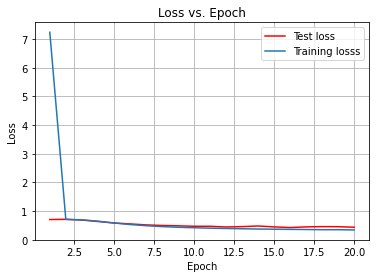

In [29]:
def plot_loss(history):
    '''Function to plot the loss vs. epoch'''
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color = 'red', label = 'Test loss')
    plt.plot(x, train_loss, label = 'Training losss')
    plt.legend()
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    
plot_loss(historyEMB)    

The loss function appears relatively well behaived. The loss decreases rapidly and then plateaus. 

Run the code below to examine the accuracy vs. epoch.

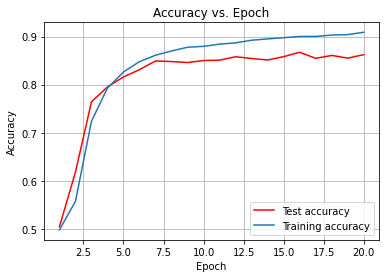

In [31]:
def plot_accuracy(history):
    train_acc = history.history['acc']
    test_acc = history.history['val_acc']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = 'red', label = 'Test accuracy')
    plt.plot(x, train_acc, label = 'Training accuracy')
    plt.legend()
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')  
    
plot_accuracy(historyEMB) 

The behavior of accuracy vs epoch is similarly well behaived like the loss function. 

### 2.3 RNN applied to embedded space

## Exercise 3-2:

> **Exercise 3-2:** You will now try the same experiment, but using an RNN layer. Do the following:   
> 1. Copy the model code you created for Exercise 3-1. 
> 2. Change the model name to RNN1.
> 3. Substitute a [tensorflow.keras.layers.SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layer for the hidden fully connected layer, with 32 unites and `kernel_regularizer=regularizers.l2(0.5)` as arguments.
> 3. Execute your this code and observe the results. 

In [40]:
## Your code goes here
RNN1 = Sequential()
RNN1.add(Embedding(10000, 
                   8, 
                   input_length=max_review_length))
#The simple RNN is expecting a 3D array, compared to the fully connected layer from before
#For that reason the Flatten Layer is removed
#RNN1.add(Flatten())
RNN1.add(SimpleRNN(32,
               kernel_regularizer=regularizers.l2(0.5)))
RNN1.add(Dense(1, 
               activation = 'sigmoid'))

#Summary of Model
RNN1.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 250, 8)            80000     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                1312      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 81,345
Trainable params: 81,345
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Model Compilation
RNN1.compile(optimizer='RMSprop',loss='binary_crossentropy',metrics=['acc'])

> Compare the complexity of recurrent neural network model to the small fully connected model you created for Exercise 3-1. In one or two sentences, explain how this difference can arise from using recurrent layers vs. fully connected layers.     

> **End of exercise.**   

> **Answer:**    

Execute the code in the cell below to train this model. 

In [36]:
historyRNN = RNN1.fit(train_text, train_labels,
                   epochs = 20,
                   batch_size = 1024,
                   validation_data = (test_text, test_labels))

Epoch 1/20
25/25 [==============================] - 4s 151ms/step - loss: 6.0807 - acc: 0.5297 - val_loss: 5.4527 - val_acc: 0.5333
Epoch 2/20
25/25 [==============================] - 3s 132ms/step - loss: 4.9638 - acc: 0.6408 - val_loss: 4.5297 - val_acc: 0.5500
Epoch 3/20
25/25 [==============================] - 3s 127ms/step - loss: 4.0737 - acc: 0.6896 - val_loss: 3.6869 - val_acc: 0.6448
Epoch 4/20
25/25 [==============================] - 3s 128ms/step - loss: 3.3058 - acc: 0.7577 - val_loss: 2.9216 - val_acc: 0.7217
Epoch 5/20
25/25 [==============================] - 3s 130ms/step - loss: 2.6835 - acc: 0.7315 - val_loss: 2.4068 - val_acc: 0.7367
Epoch 6/20
25/25 [==============================] - 3s 135ms/step - loss: 2.1307 - acc: 0.7760 - val_loss: 1.8227 - val_acc: 0.7974
Epoch 7/20
25/25 [==============================] - 4s 174ms/step - loss: 1.6804 - acc: 0.7949 - val_loss: 1.4347 - val_acc: 0.8014
Epoch 8/20
25/25 [==============================] - 5s 196ms/step - loss: 1.

The loss and accuracy achieved with the RNN layer is similar to, but not quite as good as the first model. For the application the recurrence is evidently not helpful. 

Execute the code in the cell below and examine the loss vs. epoch for this model. 

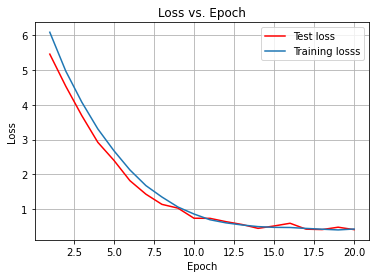

In [37]:
plot_loss(historyRNN)    

The loss function looks rather erratic across the epochs. This may (or may not) be a sign that the training of this model with so many parameters is struggling. 

Execute the code in the cell below ad examine the result. 

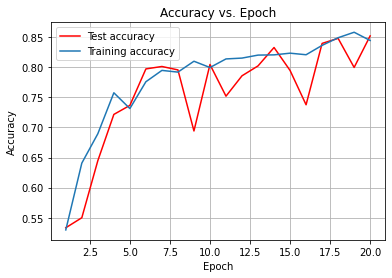

In [38]:
plot_accuracy(historyRNN) 

## Exercise 3-3:

> **Exercise 3-3:**  Compare these results to the those obtained with the fully connected neural network. In one or two sentences, answer the following  questions.   
> 1. Are the two sets of results significantly different?    
> 2. Consider that a BOW is used to create the embedding. How might this explain the comparison?  

> **Answer:** 
> 1.        
> 2.      

***
**Note:** For production work with embedding layers, pretrained models are generally used as a starting point. These models have been trained on a wide range of corpora. Therefore, these models are likely to be more powerful and less susceptible to unexpected behavior when faced with new input sequences. 
***

## 3.0 Sequence generation with RNNs

There are many interesting applications which generates a sequnce given a, possibly vector, input. A few of the applications of such a system include:
- A speach generation for a question-response system, where the output sequence is a response to a question type.
- Generating the words of image captions given the class of the image.  

A schematic architecture for a sequence generation RNN is shown in Figure 3.1 below. This is a simple example of a **generative model**. That is, it generates a squence in response to the input. We can understand the operation of this network as follows:
1. The network has a single input, $x$. 
2. The activations at a step $t$ in the sequence $h^{(t)}$ are determined by the value of $x$ and the expected value of the output $y^{(t)}$.
3. The loss function at each time step $t$, $L^{(t)}$, has two arguments $y^{(t-1)}$ and $\hat{y}^{(t)}$. 

<img src="img/SequenceGenRNN.JPG" alt="Drawing" style="width:475px; height:400px"/>
<center>Figure 3.1. Sequence generation with RNN</center>

## 4.0 Adding depth to RNNs

The RNN architectures we have discussed so far in this lesson have been shallow with only a single recurrent hidden layer. Having a single hidden layer limits the representation capacity of the RNN. It is an attractive concept to add additional layers 

To overcome the limitations of a single hidden recurrent layers, deep architectures can be used in principle. There are serveral possibilites for adding depth to the basic RNN architecture. While these ideas are not new, none is completely satisfactory, and research on alternatives continue.

One possibible archietecture is shown in Figure 4.1. This architecture takes a simple approach of stacking recurrent layers. This architecture can be effective in some cases, but suffers from being difficult to train, particularly with both depth and many time steps. 

<img src="img/DeepRNN1.JPG" alt="Drawing" style="width:200px; height:400px"/>
<center>Figure 4.1. Basic deep RNN</center>

Another possibility is to add another neural network in the recurrence loop is shown in Figure 4.2. The chosen depth and breath of this additional network can add significant capacity to the model. 

The delay caused by the additional neural network affects the behavior of the recurrence relationship. A solution to this problem is to add the **skip loop** shown in Figure 4.2. The skip loop makes the recurrence responsive to each time step. The skip loop is essentially just another memory, with another assoicated set of weights. 

<img src="img/DeepRNNSkip.jpg" alt="Drawing" style="width:250px; height:400px"/>
<center>Figure 4.2. RNN with skip connection</center>



As with other deep RNN architectures the ones shown in Figures 4.1 and 4.2 are not ideal.  Training can prove to be slow and difficult as we will discuss in the next section. 

## 5.0 RNNs with memory

In this section we will explore **long-short term memory (LSTM)** neural networks and a related architecture known as **gated recurrent units (GRU)**. These architectures are the backbone of many real-world deep learning applications. LSTM and GRU networks are used for machine translation, NLP,and speach recognition to name just a few. In fact, virtually all large-scale production applications of RNNs use some kind of memory architecture. 

LSTM and GRU networks have proven farily easy to train.  This is in contrast to simple recurrent neural networks, which can prove difficult to train. The difficulty training is generally the result of the **vanishing gradient** and **exploding gradient** problems discussed in the optimizatiton lesson. To gain some insight into why this might be, consider the recurrence relationship with a single input, $s^{(t)}$, after $n$ time steps:

$$s^{(t+n)} = f(f(....f(f(s^{(t)}; \theta));\theta)$$

Now if maginitude of $f(s; \Theta)$ is greater than $1.0$ the output value will increase exponentially, leading to an exploding gradinet after a long sequence. Conversly, if the maginitude of $f(s; \Theta)$ is less than $1.0$ the output value will decrease with an exponential decay, and the gradient will vanish after a long sequence. 

What can be done to correct the aforementioned situation? One effective solution is to add memory to the RNN. The memory makes the RNN sensitive to multiple time scales. Along with the memory as series of **forget gates** are added. Forget gates allow the the network to operate with multiple time scales. Limiting memory time limits the number of time periods for recurrence which limits vanishing and exploding gradients.  

A readable summary and comparison of LSTM and GRU architectures can be found in the [paper by Chung et. al.](https://arxiv.org/abs/1412.3555). Chung et. al. compare the performance of both architectures for serveral tasks and datasets and find that which works better is dataset and task dependent.

### 5.1 LSTM networks

An example of a neural network with memory and forget gates, known as an LSTM, is illustrated in Figure 5.1 below. This architecture was originally proposed by Hochreiter and Schmidhuber in 1997. This architecture uses a series of gates (multiplers with inputs of approximately $0$ or $1$). The memory is shown as the shaded block of the self loop. The other memory loop is shown in green. The purpose of the second memory loop is to control the activations of the forget gates. 

<img src="img/LSTM1.JPG" alt="Drawing" style="width:600px; height:450px"/>
<center>Figure 5.1. Architecture of long-short term network</center>

There are quite a few forget gates in the architecture shown in Figure 5.1. The activation or output from the network can be written:

$$\hat{y}^{(t)}_i = \sigma^{(t)}_i \cdot tanh(y^{(t)}_i)$$

Notice that the nonlinearity for the activation is given by the $tanh$ function. The gating function is determined by a sigmoid function:

$$\sigma^{(t)}_i =  \sigma \big(V_{(o)} s^{(t)}_i + U_{(o)} x_i^{(t)} + W_{(o)} h^{(t-1)}_i \big)$$

The **state** of the memory loop is a linear combination of the input and the memory. This relationship can be expressed as:

$$s^{(t)}_i = f^{(t)}_i \cdot s^{(t)}_i + i^{(t)}_i \cdot s^{(t-1)}_i$$

Where the new memory state is expressed as:

$$s^{(t)}_i = tanh(U_{c} x_i^{(t)} + W_{c} h^{(t-1)}_i)$$

The activations of the forget gate and input gate are expressed the the sigmoidal functions:

$$f^{(t)}_i = \sigma \big(V_{(f)} x^{(t)} + U_{(f)} x_i^{(t)} + W_{(f)} h^{(t-1)}_i \big)\\
i^{(t)}_i = \sigma \big(V_{(i)} x^{(t)} + U_{i} x_(i)^{(t)} + W_{(i)} h^{(t-1)}_i \big)$$  



$$f^{(t)}_i = \sigma \big(\mathbf{b}^{(f)} x^{(t)} + \mathbf{U}^{(f)} x^{(t)} + \mathbf{W}^{(f)} h^{(t-1)} \big)$$


### 5.2 GRU networks

The numerious forget gates in the LSTM network leads to some complexity in understanding and in training. The GRU architecture by Cho et. al. in 2014 as a possible simplification of a RNN with multiple time scales. The GRU architecture does not require an explicit memory unit. Instead, GRUs use a weighted decay function for the output activation:

$$h_i^{(t)} = \big( 1 - z _i^{(t)} \big) h_i^{(t-1)} + z _i^{(t)} \tilde{h}_i^{(t-1)}$$

$$h^{(t)} = \big( 1 - z^{(t)} \big) h^{(t-1)} + z^{(t)} \tilde{h}^{(t-1)}$$

The schematic architecture of a GRU network is shown in figure 5.2. Notice that there are two loops, but no memory. This arrangement effectively implements the relationship shown in the equation above. 

<img src="img/GRU.JPG" alt="Drawing" style="width:750px; height:400px"/>
<center>Figure 5.2. Schematic architecture of GRU network</center>

The update gate is controled by the a sigmoidal function of the following form: 

$$z _i^{(t)} = \sigma \big( U_{(z)} h_i^{(t-1)} + W_{(z)} x^{(t)}_i \big)$$

$$z^{(t)} = \sigma \big( U_{(z)} h^{(t-1)} + W_{(z)} x^{(t)} \big)$$

The **candidate activation**, $\tilde{h}_i^{(t-1)}$, is computed in a similar manerr to the typical recurrent unit using the following relationship: 

$$\tilde{h}_i^{(t-1)} = tanh \big( U( r_i^{(t)} \odot h^{(t-1)}_i) + W_{(z)} x^{(t)}_i \big)$$

The activation of the reset gate are determined by the following relationship:

$$r_i^{(t)} = \sigma \big( U_{(r)} h_i^{(t-1)} + W_{(r)} x^{(t)}_i \big)$$

You can see from the above equations that the architecture GRU is indeed a simplification when compared to the LSTM architecture.

### 5.3 A GRU example

## Exercise 3-4:

> **Exercise 3-4:** You will now try the same experiment, but using an GRU layer. Do the following:   
> 1. Copy the model code you created for Exercise 3-1. 
> 2. Change the model name to GRU1.
> 3. Substitute a [tensorflow.keras.layers.GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) layer for the hidden fully connected layer, with 32 unites and `kernel_regularizer=regularizers.l2(0.5)` as arguments.
> 3. Execute your this code and observe the results. 

In [41]:
## Your code goes here
GRU1 = Sequential()
GRU1.add(Embedding(10000, 
                   8, 
                   input_length=max_review_length))
GRU1.add(GRU(32,
               kernel_regularizer=regularizers.l2(0.5)))
GRU1.add(Dense(1, 
               activation = 'sigmoid'))

#Summary of Model
GRU1.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 250, 8)            80000     
                                                                 
 gru (GRU)                   (None, 32)                4032      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 84,065
Trainable params: 84,065
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Model Compilation
GRU1.compile(optimizer='RMSprop',loss='binary_crossentropy',metrics=['acc'])

> 5. Now, execute the code in the cell below and examine the results. 

In [43]:
historyGRU1 = GRU1.fit(train_text, train_labels,
                   epochs = 20,
                   batch_size = 1024,
                   validation_data = (test_text, test_labels))

Epoch 1/20
25/25 [==============================] - 14s 512ms/step - loss: 6.9088 - acc: 0.5438 - val_loss: 5.7539 - val_acc: 0.6381
Epoch 2/20
25/25 [==============================] - 15s 593ms/step - loss: 4.9960 - acc: 0.6256 - val_loss: 4.2082 - val_acc: 0.6024
Epoch 3/20
25/25 [==============================] - 16s 638ms/step - loss: 3.6256 - acc: 0.6246 - val_loss: 2.9546 - val_acc: 0.7538
Epoch 4/20
25/25 [==============================] - 16s 645ms/step - loss: 2.6111 - acc: 0.5812 - val_loss: 2.1358 - val_acc: 0.7351
Epoch 5/20
25/25 [==============================] - 16s 635ms/step - loss: 1.8311 - acc: 0.6612 - val_loss: 1.6054 - val_acc: 0.5005
Epoch 6/20
25/25 [==============================] - 16s 641ms/step - loss: 1.3326 - acc: 0.6463 - val_loss: 1.0852 - val_acc: 0.8123
Epoch 7/20
25/25 [==============================] - 16s 636ms/step - loss: 0.9656 - acc: 0.7437 - val_loss: 0.8172 - val_acc: 0.8014
Epoch 8/20
25/25 [==============================] - 16s 654ms/step - 

> 6. Next, execute the code in the cell below to display the plot of loss vs. epoch. 

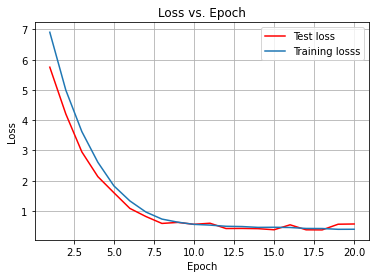

In [44]:
plot_loss(historyGRU1)   

> 7. Execute the code in the cell below to display the plot of accuracy vs. epoch. 

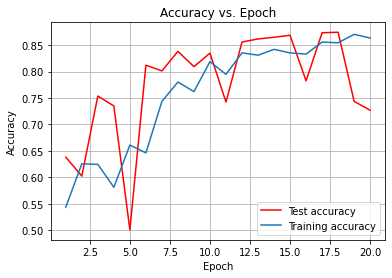

In [45]:
plot_accuracy(historyGRU1) 

> **End of exercise.**  Examine training and test results, particularly the test accuracy, over the epochs. What can you say about the possible need for better regularization and why?     

> **Answer:**    

## 6.0 Regualarization of RNN

Like all neural networks regularization is typically applied to RNNs. Both l1 and l2 regularization are commonly used. In fact, the foregoing examples use some mild l2 regularization. 

> **Note:** Regularization will be discussed in greater detail in the next lesson. For now, you will experiment with some basic methods. 

### 6.1 Dropout regularization

As you have seen, dropout regularization can be quite effective for fully connected neural networks. However, dropout has proven difficult to deal with for RNNs. The usual dropout algorithm causes problems with BPTT. This problem arises because the Bernoulli sampling at each time step causes instability during BPTT. 

A solution to this problem has only recently been found by Gal and Ghahramani (2016) and Gal (2016). In these highly technical papers the concept of using dropout as a sampling method for a Gaussian Bayesian model is developed. The solution is to use a special case of dropout in which the Bernoulli sampling is not updated at each forward pass through the network. This method is called **recurrent dropout**. 

****
**Note:** This implementatione of the recurrent dropout algorithm in Keras was done by Gal as part of his thesis research. 
****

## Exercise 3-5:

> **Exercise 3-5:** You will now try adding a recurrent dropout regularizer to your GRU network. Do the following:   
> 1. Copy your code from Exercise 3-4.
> 2. Change the model name to GRU2.  
> 3. Add the following argument to the GRU layer, `recurrent_dropout=0.1`, and set the following argument, `kernel_regularizer = regularizers.l2(0.005)`. Notice this is a lower hyperparameter value for the L2 regularizer.  
> 4. Execute your code. 

In [46]:
## Your code goes here
GRU2 = Sequential()
GRU2.add(Embedding(10000, 
                   8, 
                   input_length=max_review_length))
GRU2.add(GRU(32,
             recurrent_dropout=0.1,
             kernel_regularizer=regularizers.l2(0.005)))
GRU2.add(Dense(1, 
               activation = 'sigmoid'))

#Summary of Model
GRU2.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 250, 8)            80000     
                                                                 
 gru_1 (GRU)                 (None, 32)                4032      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 84,065
Trainable params: 84,065
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Model Compilation
GRU2.compile(optimizer='RMSprop',loss='binary_crossentropy',metrics=['acc'])


> 5. Now, execute the code in the cell below to fit the model and examine the result.

In [50]:
historyGRU2 = GRU2.fit(train_text, train_labels,
                   epochs = 20,
                   batch_size = 1024,
                   validation_data = (test_text, test_labels))

Epoch 1/20
25/25 [==============================] - 18s 702ms/step - loss: 0.7512 - acc: 0.5628 - val_loss: 0.7365 - val_acc: 0.5786
Epoch 2/20
25/25 [==============================] - 27s 1s/step - loss: 0.7002 - acc: 0.6601 - val_loss: 0.6178 - val_acc: 0.7532
Epoch 3/20
25/25 [==============================] - 28s 1s/step - loss: 0.5695 - acc: 0.7612 - val_loss: 0.5260 - val_acc: 0.8040
Epoch 4/20
25/25 [==============================] - 30s 1s/step - loss: 0.4691 - acc: 0.8142 - val_loss: 0.4356 - val_acc: 0.8387
Epoch 5/20
25/25 [==============================] - 31s 1s/step - loss: 0.4132 - acc: 0.8382 - val_loss: 0.4758 - val_acc: 0.7962
Epoch 6/20
25/25 [==============================] - 31s 1s/step - loss: 0.3838 - acc: 0.8550 - val_loss: 0.3639 - val_acc: 0.8556
Epoch 7/20
25/25 [==============================] - 32s 1s/step - loss: 0.3423 - acc: 0.8703 - val_loss: 0.3829 - val_acc: 0.8516
Epoch 8/20
25/25 [==============================] - 32s 1s/step - loss: 0.3217 - acc: 0

> 6. PLot the curve of loss vs epoch by executing the code in the cell below. 

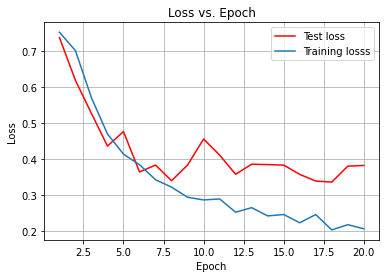

In [51]:
plot_loss(historyGRU2)   

> 7. Execute the coded in the cell below to plot the curve of accuracy vs. epoch. 

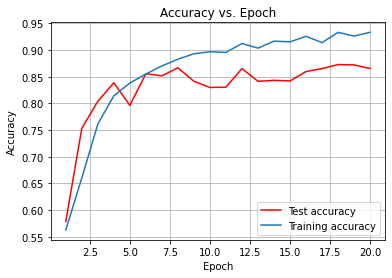

In [52]:
plot_accuracy(historyGRU2) 

> Examine the the test and training curves and compare them to the GRU model without the recurrent dropout. What does this tell you about the effectiveness of the recurrent dropout regulariaiton and why?    

> **End of exercise.**

> **Answer:**    

### 7.0 Bidirectional RNNs

Up until now we have worked only with RNNs which take steps along a sequence in one direction. As a result, we said these models are causal. However, there are many situations where causality is not important. A few examples include:  
- NLP applications, where the order words are processed is not important. 
- Handwritting recognition, where characters can be recognized in any order. 
- Speach recognition, where the phenomes of a captured utternance are analyized as a group. 
- Figure captioning, where the figure can be understood scanning left to right, right to left, top to bottom and bottom to top. In fact, a 4-directional neural network architecture can be applied to this case. 

Given that order of processing for many sequences does not mater it is possible to go in both directions at once. RNNs that perform such processing are know as **bidirectional RNNs**. An example of a simple bidirectional RNN achitecture is shown in figure 7.1 below. 

<img src="img/Bidirectional1.JPG" alt="Drawing" style="width:700px; height:450px"/>
<center>Figure 7.1. Architecture of simple bidirectional RNN</center>

It is relatively straight forward to derrive the propagtion equations for  the case of a simple bidirectional RNN. These equations are  shown below. 

$$a^{(t)} = b + W h^{(t-1)} + Ux^{(t)}\\
i^{(t)} = d + Q g^{(t+1)} + Rx^{(t)}\\
h^{(t)} = tanh(a^{(t)})\\
g^{(t)} = tanh(i^{(t)})\\
o^{(t)} = c + Vh^{(t)} + Sg^{(t)}\\
\hat{y}^{(t)} = softmax(o^{(t)})$$

In addition to the usual weight tensors, $W$ and $U$ ,for the forward case, there are corresponding tensors, $Q$ and $R$ for the backward case. The activation of the forward case is given by $h^{(t)}$, and for the backward case, $g^{(t)}$. The output of the network, $\hat{y}^{(t)}$, is the softmax of the linear combination of these forward and backward activations with weight tensors $V$ and $S$. There bias tensors are required, $c$, $b$, and $d$.

By examining the above equations, one can see that bidirectional RNNs are **non-causal**. As already stated, this property may actually be an advantage in many applications. 

## Exercise 3-6:

> **Exercise 3-6:**  You will now try adding using a bidirectional GRU. Do the following:   
> 1. Copy your code from Exercise 3-5.
> 2. Change the model name to bidirectional.  
> 3. To make the GRU layer bidirectional you wrap the GRU layer you already created in the [tensorflow.keras.layers.recurrent_layers.bidirectional](https://keras.io/api/layers/recurrent_layers/bidirectional/) layer.   
> 4. Execute your code.  

In [48]:
## Your code goes here
bidirection = Sequential()
bidirection.add(Embedding(10000, 
                   8, 
                   input_length=max_review_length))
bidirection.add(Bidirectional(GRU(32,
             recurrent_dropout=0.1,
             kernel_regularizer=regularizers.l2(0.005))))
bidirection.add(Dense(1, 
               activation = 'sigmoid'))

#Summary of Model
bidirection.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 250, 8)            80000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               8064      
 l)                                                              
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 88,129
Trainable params: 88,129
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Model Compilation
bidirection.compile(optimizer='RMSprop',loss='binary_crossentropy',metrics=['acc'])

> 5. Next, execute the code in the cell below to fit this model and examine the results. 

In [ ]:
historyBi = bidirection.fit(train_text, train_labels,
                   epochs = 20,
                   batch_size = 1024,
                   validation_data = (test_text, test_labels))

Epoch 1/20
25/25 [==============================] - 72s 3s/step - loss: 0.8041 - acc: 0.5360 - val_loss: 0.7801 - val_acc: 0.6252
Epoch 2/20
25/25 [==============================] - 86s 3s/step - loss: 0.7461 - acc: 0.6560 - val_loss: 0.6331 - val_acc: 0.7827
Epoch 3/20
25/25 [==============================] - 95s 4s/step - loss: 0.6102 - acc: 0.7632 - val_loss: 0.5894 - val_acc: 0.7335
Epoch 4/20
25/25 [==============================] - 101s 4s/step - loss: 0.5072 - acc: 0.8067 - val_loss: 0.4593 - val_acc: 0.8139
Epoch 5/20
13/25 [==============>...............] - ETA: 43s - loss: 0.4625 - acc: 0.8238

6. Execute the code in the cell below to plot the loss vs. epoch. 

In [ ]:
plot_loss(historyBi)   

7. Execute the code in the cell below to plot the accuracy vs. epoch. 

In [ ]:
plot_accuracy(historyBi)

> In one or two sentences, answer the following questions: 
> 1. Compare the number of learnable parameters of the bidirectional and single directional GRU models. Does the difference make sense and why? 
> 2. In terms of complexity, model capacity and difficulty of learning how do you think the bidirectional and single directional models compare and why? 
> 3. Compare the results of the various RNN models tried for this problem. WHat does the similarity across models tell you about the difficulty of classifying a concept like sentiment which fundamentally requires understanding?  
> **End of exercise.**

> **Answers:**  
> 1.    
> 2.     
> 3.      

## 8.0 RNNs Vs. CNNs

It may have caught your notice that convolutional neural networks could be applied to many of the applications discussed in this lesson. This is in fact the case. For example, a one-dimensional seequence can be modeled by either an RNN or a one-dimensional covnet. 

In some cases covnets have proved superior. This superior performance likely results from the simpler and easier to train model. However, if the underlying process operates over long time scales, then an RNN with memory will likely be superior, since covnets have no memory. 

Emperical evidence indicates that one can only decide which architecture is better for a given application by either deep understanding  of the underlying process, actual testing or both. Testing the various purmutations of these two basic architectures can be quite time consumming. However there  

#### Copyright 2018, 2019, 2022, Stephen F Elston. All rights reserved. 